In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
df = pd.read_json('./Data/db_export.csv', encoding='ISO-8859-1')
df.info()
df.head()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 21 columns):
1_1                      51 non-null int64
1_2                      51 non-null int64
1_3                      51 non-null int64
1_4                      51 non-null int64
1_5                      51 non-null int64
1_6                      51 non-null object
2_1                      51 non-null object
2_2                      51 non-null int64
2_3                      51 non-null int64
2_4                      51 non-null int64
3_1                      51 non-null int64
3_2                      51 non-null int64
3_3                      51 non-null int64
3_4                      51 non-null int64
3_5                      51 non-null int64
3_6                      51 non-null int64
3_7                      51 non-null int64
computerButtonClicked    51 non-null int64
email                    51 non-null object
themeChosen              51 non-null int64
timeToComplete           51 non-nu

,1_1,1_2,1_3,1_4,1_5,1_6,2_1,2_2,2_3,2_4,...,3_2,3_3,3_4,3_5,3_6,3_7,computerButtonClicked,email,themeChosen,timeToComplete
0,2,1,1,2,2,"[1, 2, 4, 5]","[1, 7]",1,2,2,...,4,3,4,3,2,1,0,tlkramer@smu.edu,3,51.131
1,1,1,1,1,1,"[1, 3, 4, 5, 6]",[5],2,2,2,...,4,3,4,3,2,1,0,dcsanchez@smu.edu,1,317.141
2,2,1,1,2,2,"[1, 2, 4, 5]",[5],1,2,2,...,3,2,3,2,3,1,0,ccjohnson@smu.edu,1,179.159
3,1,1,1,2,3,"[1, 2, 4]",[7],1,2,2,...,4,3,4,3,3,1,0,awoodruff@smu.edu,2,84.053
4,1,1,2,3,3,"[1, 2, 4, 5]","[1, 4]",1,2,2,...,4,3,4,1,1,1,0,chalquist@smu.edu,3,73.996


First, we'll need to extract the questions and their choices from the webpage

In [3]:
# open the webpage to parse for questions
with open ('./../AB-Testing-Form/templates/index.phtml') as fp:
    soup = BeautifulSoup(fp, 'html.parser')

In [4]:
survey_questions = {}  # question : [choices]

In [5]:
# for each page in the form
pages = soup.find_all('div', class_='page')
for p in range(len(pages)):
    
    if p > 0:  # ignore the first page
        questions = pages[p].find_all('div', class_='row section')
        
        for q in questions:
            # strip the number from the question
            question_title = q.find('h5').contents[1]
            
            # option tags surrounding the choices
            options = q.find('div', class_="input-field col s12 m8"
                            ).find('select').find_all('option')
            
            choices = []
            
            # keep track of those choices that aren't disabled
            for o in options:
                if 'disabled' not in str(o):
                    choices.append(o.contents[0])

            survey_questions[question_title] = choices 

In [6]:
# list of dictionaries containing responses and their occurrences
responses = []

df_questions = df

# remove those instances that weren't completed
if 'dropout' in df.columns:
    df_questions = df[df.dropout != 'true']

# remove non-questions from the data
df_questions = df_questions.iloc[:, :-6]  

for column in df_questions:
    col = df_questions[column]
    
    # questions with one option
    if col.dtype == "int64":
        responses.append(dict(sorted(Counter(col).items())))
    else:  # questions with multiple values
        # join the responses
        combined_responses = [int(inner) for outer in col 
                              for inner in outer]
        responses.append(dict(sorted(Counter(combined_responses).items())))

In [7]:
responses

[{1: 35, 2: 15, 3: 1},
 {1: 35, 2: 16},
 {1: 46, 2: 5},
 {1: 11, 2: 33, 3: 7},
 {1: 19, 2: 24, 3: 8},
 {1: 51, 2: 38, 3: 16, 4: 46, 5: 48, 6: 7},
 {1: 20, 3: 4, 4: 14, 5: 18, 7: 2},
 {1: 46, 2: 5},
 {1: 10, 2: 41},
 {1: 20, 2: 28, 3: 2, 4: 1},
 {1: 2, 2: 9, 3: 20, 4: 20},
 {2: 2, 3: 13, 4: 36},
 {2: 5, 3: 46},
 {2: 3, 3: 3, 4: 45},
 {1: 12, 2: 11, 3: 28}]

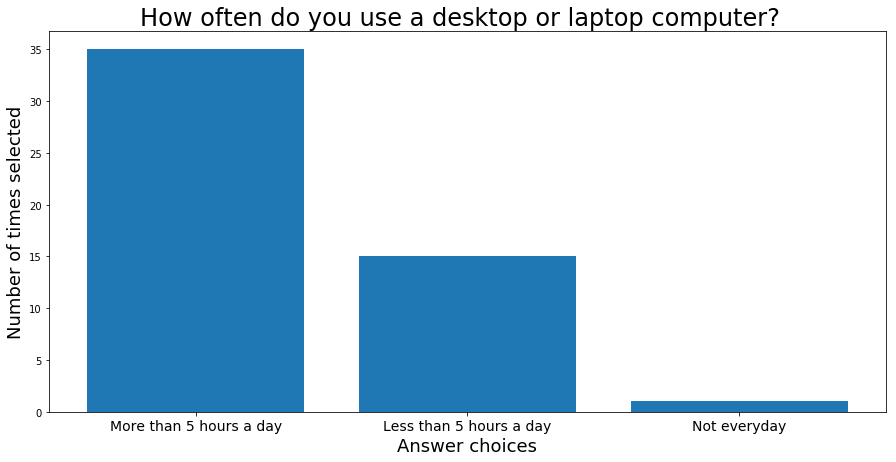

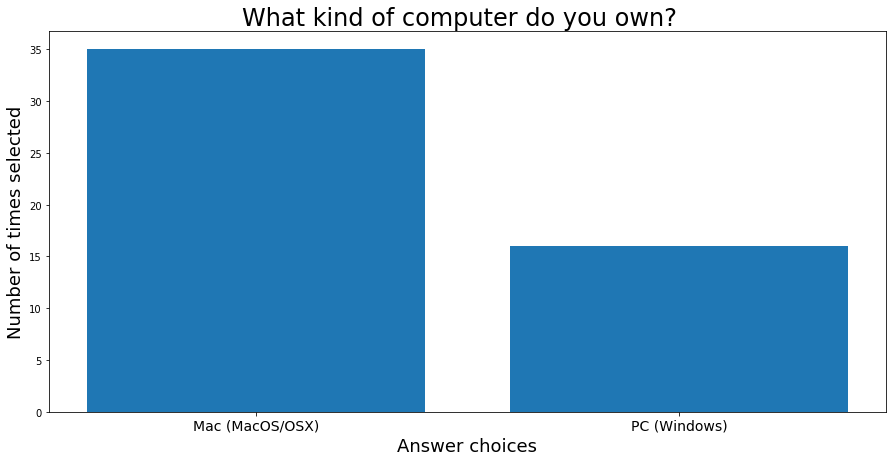

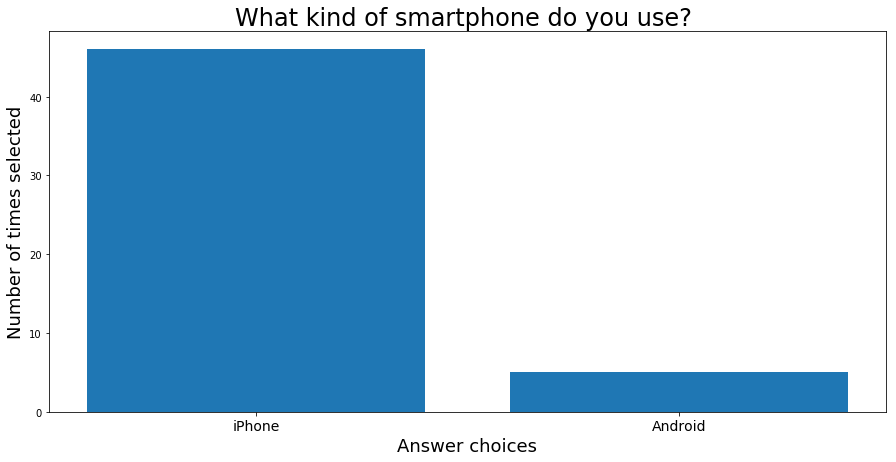

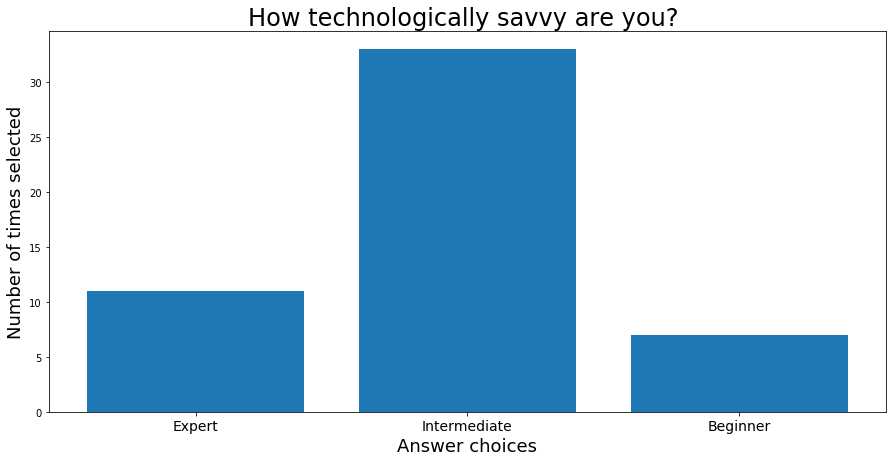

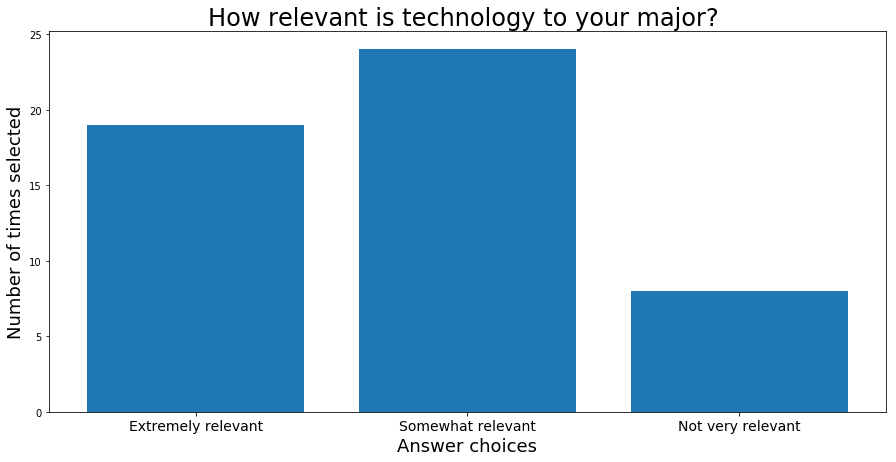

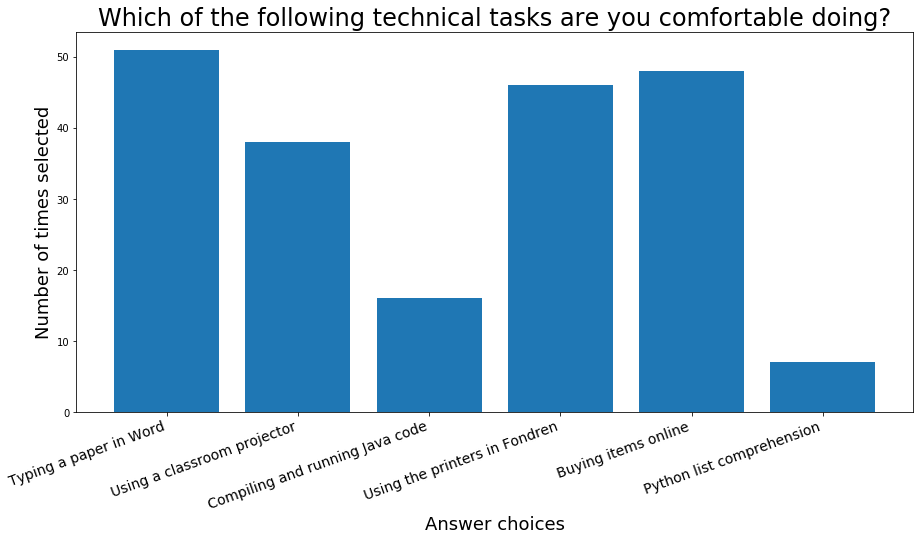

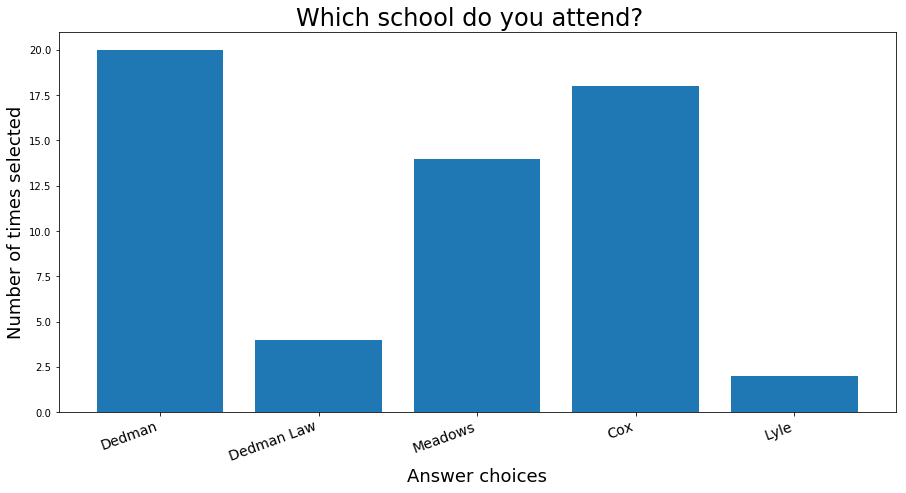

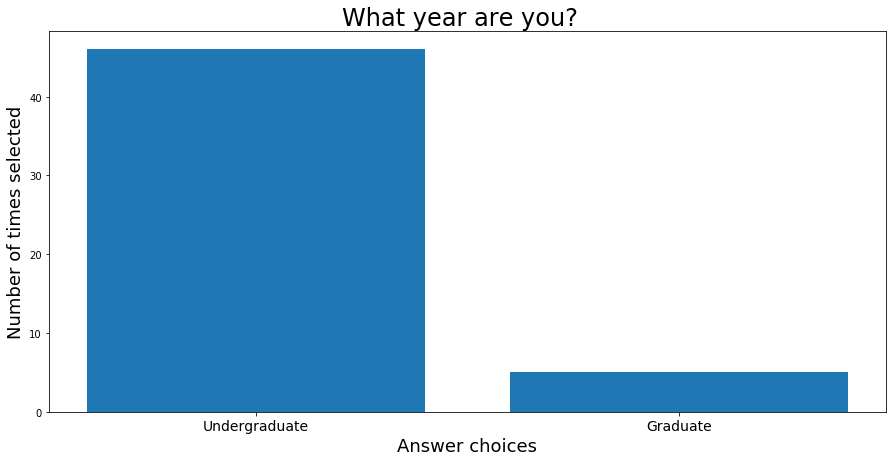

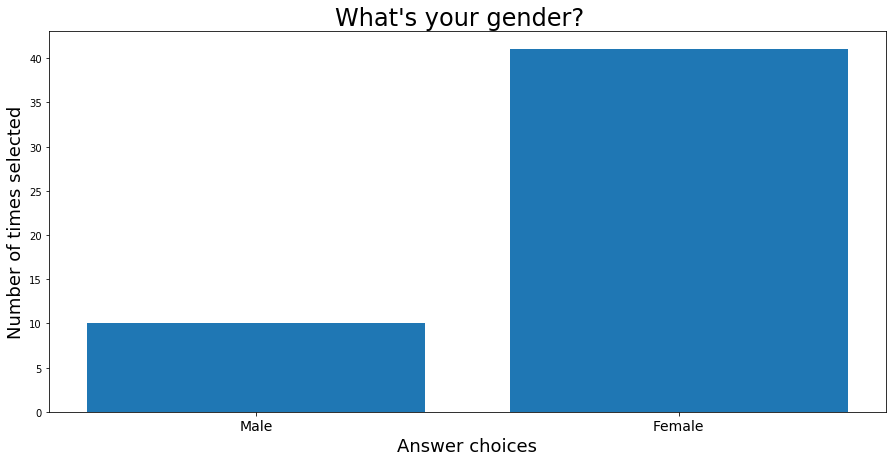

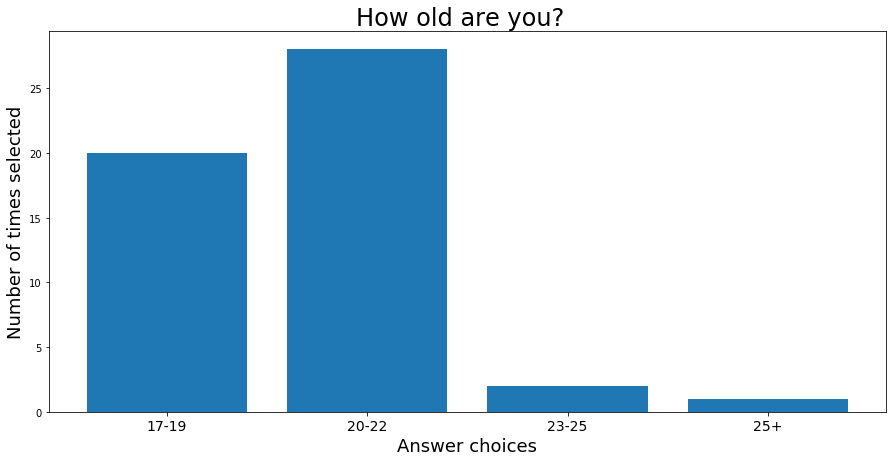

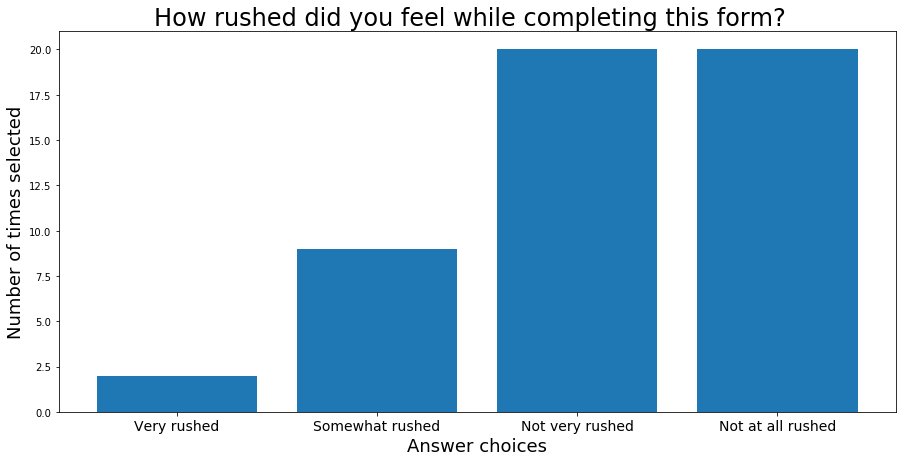

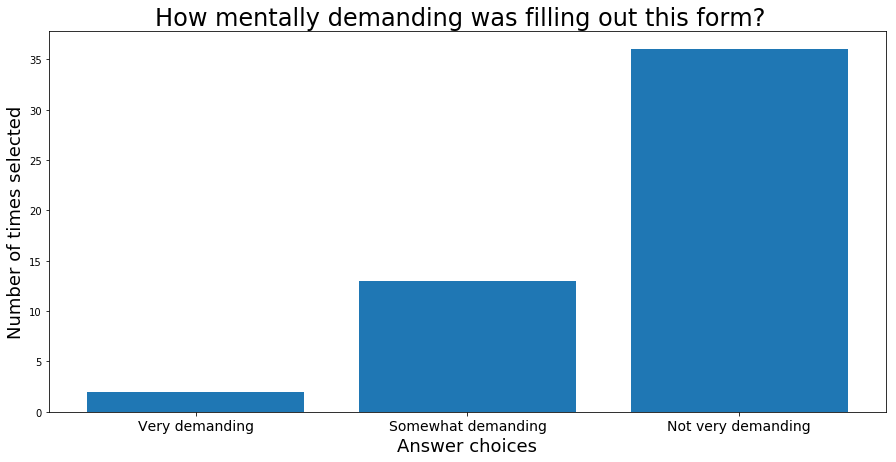

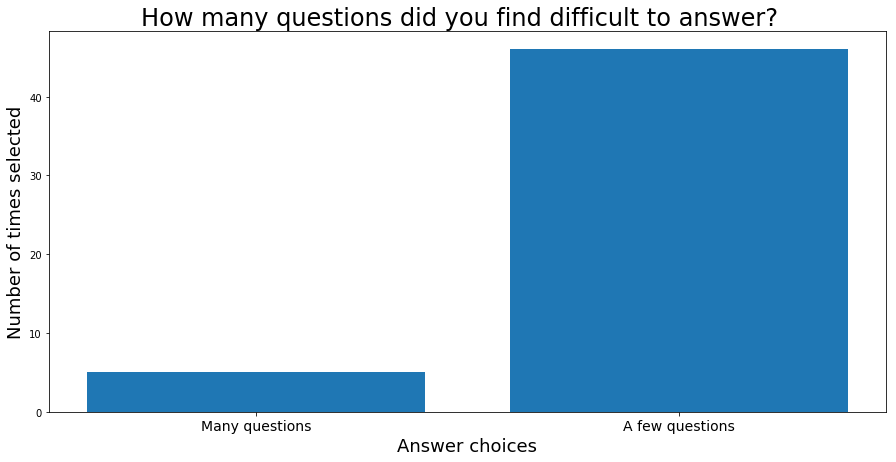

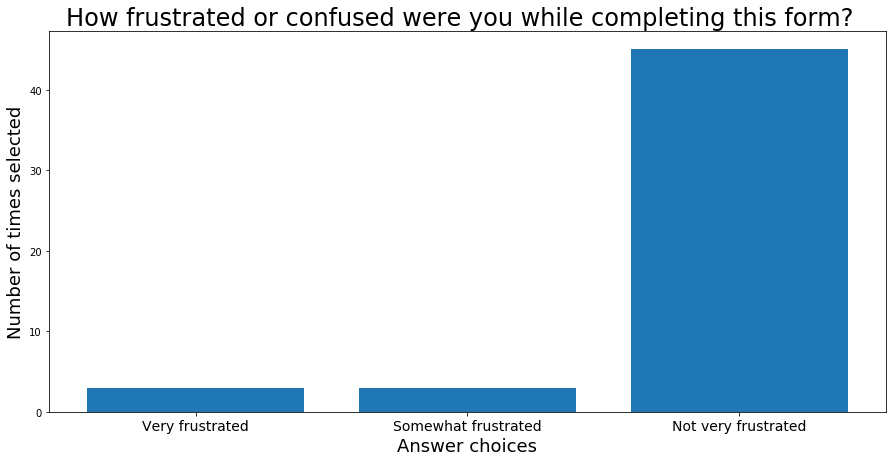

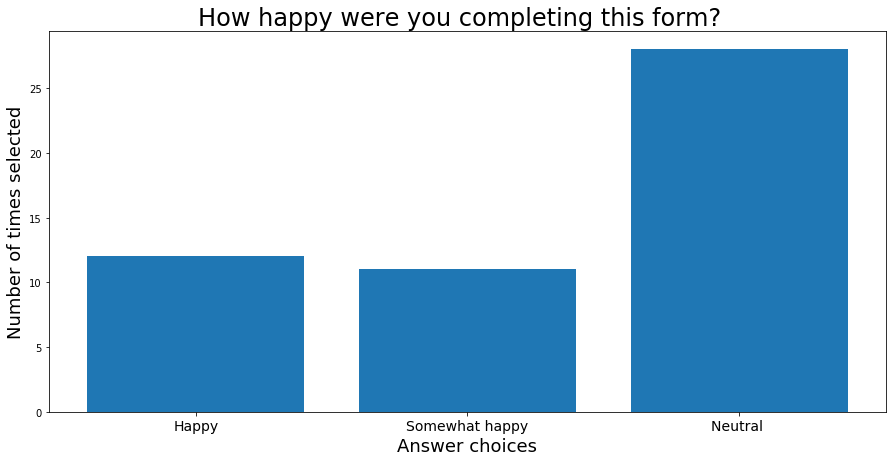

In [26]:
for r in range(len(responses)):
    # total numbers of times options were chosen
    totalled_answers = responses[r].values()
    
    # text of questions and answers
    title = list(survey_questions.keys())[r]
    choices = list(survey_questions.values())[r]
    
    selected_choices = []
    
    # remove the choices that were never selected
    for c in range(1, len(choices)+1):
        if c in sorted(responses[r].keys()):
            selected_choices.append(choices[c-1])
            
    # logic for building bar chart
    y_pos = np.arange(len(selected_choices))
    plt.figure(figsize=(15,7))
    plt.bar(y_pos, totalled_answers, align='center')
    plt.xticks(y_pos, choices, size=14)
    plt.xlabel('Answer choices', size=18)
    plt.ylabel('Number of times selected', size=18)
    plt.title(title, size=24)
    
    # rotate xticks of questions with a lot of choices
    if len(selected_choices) > 4:
        plt.xticks(y_pos, choices, size=14, rotation=20, ha='right')
    
    
    plt.show()

# clean the plot object when done
plt.clf()
plt.cla()
plt.close()